In [106]:
# @title Import packages
import numpy as np
import matplotlib.pyplot as plt

# set the font size of plots
font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

- Basic setup to simulate trajectories with 3 parameters (drift, bound, starting point) using Euler Mayurama  method
	- Obtain histograms and psychometrics
	- Compare to analytic solutions, explore the error of the approximation with dt
	- Explore dependence of histograms and psychometrics with parameter values
- Add time varying bound, variability in parameters
- Explore race models

- "Optogenetic manipulations"
	- "Sensory neurons" vs "Integrator neurons"
	- Bound "deletion"
        - Other ways?

- History effects
	- Explore updates on starting point and drifts
	- Also post error slowing (increase bounds after errors)

### Basic setup

In [101]:
# @title Functions
def sim_ddm(mu=0.5, theta=1, b=0, z=0, sigma=1, n_trials=1000, dt=.001, T=10):
   # time array and prealocate results
   t = np.arange(0, T, dt)
   n_t = t.size
   S = -np.ones((n_trials,2))
   # compute time varying bounds for b != 0
   thetas = theta/(1+(b/dt*np.linspace(0, 1, n_t)))
   
   for tr in range(n_trials):
      dW   = np.random.randn(n_t,1) # noise vector
      dx   = mu*dt + sigma*dW*np.sqrt(dt)
      dx[0] += z # starting point
      x    = np.cumsum(dx,0)
    
      for ti in range(n_t):
         if x[ti] >= thetas[ti]:
            S[tr,:] = [1, t[ti]]                                         
            break
         elif x[ti] <= -thetas[ti]:
            S[tr,:] = [0, t[ti]]         
            break

   # Get the hit and error trials
   if np.sign(mu)>0:
      hits = np.where(S[:,0]==1)
      errs = np.where(S[:,0]==0)
   else:
      hits = np.where(S[:,0]==0)
      errs = np.where(S[:,0]==1)
   return S, hits, errs, thetas

def plot_rt_hist(hits, errs):
   '''
   Plot the reaction time distributions for the hit and error trials
   '''
   
   rt_hits_hist, rt_hits_bin_edges = np.histogram(hits)
   rt_errs_hist, rt_errs_bin_edges = np.histogram(errs)

   plt.figure(figsize=(5,5))
   plt.stairs(rt_hits_hist, rt_hits_bin_edges, label='hits')
   plt.stairs(rt_errs_hist, rt_errs_bin_edges, label='errors')
   plt.xlabel('Reaction time')
   plt.ylabel('Count')
   plt.legend(loc='upper right');
   return 0

def plot_psychometric(S_list, mu_list):
   '''
   Plot the psychometric curve for the given responses and drift
   parameters.
   '''
   n_mu = len(mu_list)
   a_rate = np.zeros((n_mu,))
   b_rate = np.zeros((n_mu,))
   for i in range(n_mu):
      a_rate[i] = np.sum(S_list[i]==1)
      b_rate[i] = np.sum(S_list[i]==0)
   prob_a = np.divide(a_rate, a_rate+b_rate) # probability of a

   plt.figure(figsize=(5,5))
   plt.scatter(mu_list, prob_a, color='k')
   plt.xlabel('Drift')
   plt.ylabel('Porbability of a')
   plt.xlim([np.min(mu_list)*1.05, np.max(mu_list)*1.05])
   plt.ylim([0-0.05, 1+0.05]);
   return prob_a

def plot_quantile_prob_func(S_list, hits_list, errs_list, mu_list, prob_a):
   '''
   Plot the quantile probability function for the reaction times of a
   drift diffusion model.
   '''
   n_mu = len(mu_list)
   quantile_list = np.linspace(10,90,5)
   rt_quantiles = np.nan*np.ones((n_mu, len(quantile_list)))
   for mu_i in range(n_mu): # skip drift equal to zero
      um_i = n_mu-mu_i-1 # id of drift with same magnitude but opposite sign
      if mu_list[mu_i] < 0: # drift to b
         # errors for drifts to a and b, respectively
         rt_errs = np.concatenate((S_list[um_i][errs_list[um_i][0],1],\
                                    S_list[mu_i][errs_list[mu_i][0],1]))
         rt_quantiles[mu_i,:] = np.percentile(rt_errs, quantile_list)
      elif mu_list[mu_i] > 0: # drift to a
         # hits for drifts to a and b, respectively
         rt_hits = np.concatenate((S_list[mu_i][hits_list[mu_i][0],1],\
                                    S_list[um_i][hits_list[um_i][0],1]))
         rt_quantiles[mu_i,:] = np.percentile(rt_hits, quantile_list)

   plt.figure(figsize=(5,5))
   plt.plot(prob_a, rt_quantiles, marker='x', linestyle='')
   plt.xlabel('Probability of a')
   plt.ylabel('Reaction time quantile');
   return rt_quantiles

In [ ]:
# Define DDM parameters
mu = 0.5 # drift
theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
b = 0.1 # time varying bound

# Define simulation parameters
n_trials = 1000
dt = .001
T = 10

In [ ]:
# Run DDM simulations for different drifts
n_mu = 21
mu_list = 2*np.linspace(-1, 1, n_mu)
z_list = 0.5*np.concatenate((-np.ones((10,)),\
                              np.zeros((1,)),\
                              np.ones((10,))))
b = 0
# Preallocate results
S_list = []
hits_list = []
errs_list = []
for i, mu in enumerate(mu_list):
    z = z_list[i]
    # Simulate trajectories
    S, hits, errs, thetas = sim_ddm(mu, theta, b, z, sigma, n_trials, dt, T)
    S_list.append(S)
    hits_list.append(hits)
    errs_list.append(errs)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


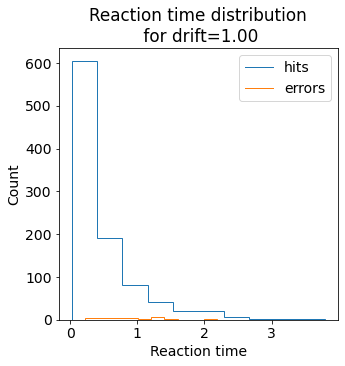

In [107]:
# Plot the reaction time distributions for the hit and error trials, for example mu
mu_i = 15 # example mu

hits = S_list[mu_i][hits_list[mu_i],1]
errs = S_list[mu_i][errs_list[mu_i],1]

plot_rt_hist(hits, errs)
plt.title('Reaction time distribution\n for drift={:.2f}'.format(mu_list[mu_i]))
plt.show()

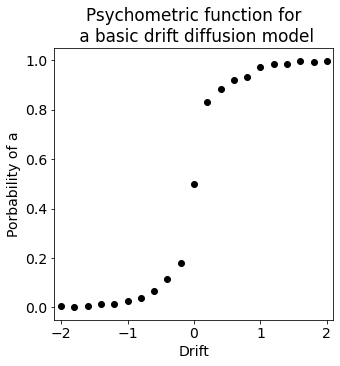

In [105]:
# Plot a psychometric curve
prob_a = plot_psychometric(S_list, mu_list)
plt.title('Psychometric function for\n a basic drift diffusion model')
plt.show()

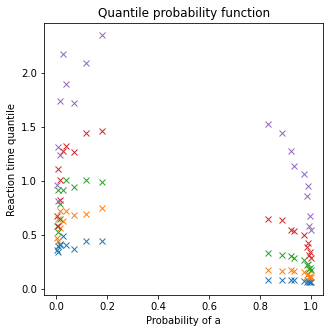

In [102]:
# Plot the quantile probability function
plot_quantile_prob_func(S_list, hits_list, errs_list, mu_list, prob_a)
plt.title('Quantile probability function')
plt.show()

Expand next cell to see solution

In [ ]:
# import numpy as np

# # Define DDM parameters
# mu = 0.5 # drift
# theta = 1 # bound
# z = 0 # starting point
# sigma = 1 # noise std

# # Define simulation parameters
# n_trials = 1000
# dt = .001
# T = 10

# # time array and prealocate results
# t = np.arange(0, T, dt)
# n_t = t.size
# S = -np.ones((n_trials,2))

# # Simulate trajectories

# for j in range(n_trials):
    
#     dW   = np.random.randn(n_t,1)
#     dx   = dW*np.sqrt(dt) + mu*dt
#     x    = np.cumsum(dx,0)
    
#     for i in range(n_t):
             
#         if (x[i] >= theta):
#            S[j,:] = [1, t[i]]                                         
#            break
#         elif (x[i] <= -theta):
#            S[j,:] = [0, t[i]]         
#            break
    